# Synthetic data

We can test our Python module doing this:

In [1]:
from src.lib import synthetic_data

(10000, 2, 6)


/tmp/ipykernel_2115214/3875174242.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  C = quad(f, A, B)[0]


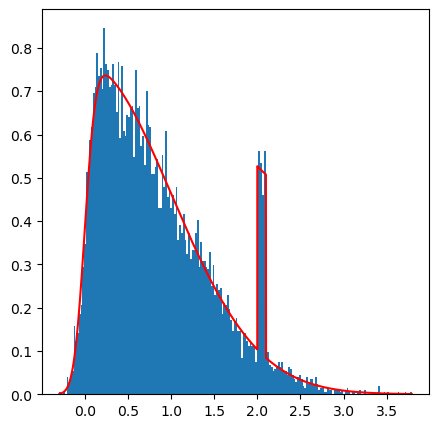

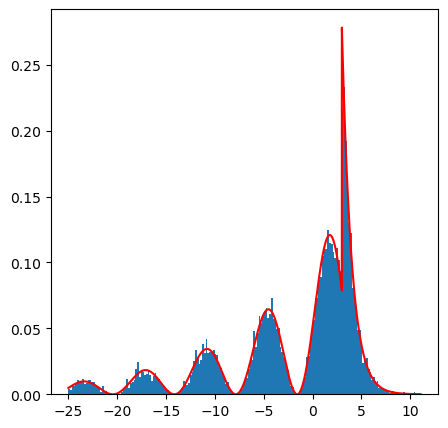

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.integrate import quad
from scipy import stats
from src.lib.synthetic_data import SyntheticData

def plot_hist_with_pdf(xs, f):
    fig, ax = plt.subplots(figsize=(5,5))

    A, B = np.min(xs), np.max(xs)

    C = quad(f, A, B)[0]
    x = np.linspace(A, B, 10000)

    ax.hist(xs, bins = 200, density = True)
    ax.plot(x, f(x) / C, color='red')
    return fig, ax

D = 2
T = 6
# lower bound, upper bound, and unormalized PDF
bounds = [(-3, 5), (-25, 20)]
f1 = lambda x: 10 * stats.norm.cdf(10 * x) * stats.norm.pdf(x) + 2 * np.where(x > 2.0, np.exp(x - 2), 0) * np.where(x < 2.1, np.exp(2.1 - x), 0)
f2 = lambda x: np.where(x > 3, np.exp(7-x), np.exp(x / 10) * (10 * np.sin(x) + 10))
# both of the two time-series will be q=3 and q=2, respecitvely
thetas = np.array([
    [-1., 0.5, -0.2, 0.8],
    [-1., 0.3, 0.9, 0.0]
    ])

synth_data = SyntheticData(
        dim_size = D,
        time_series_length = T,
        pdfs = [f1, f2],
        pdf_bounds = bounds,
        ar_q = 3,
        ar_thetas = thetas,
        cross_variables_cor_init_sigma=0.5,
        response_noise_sigma=0.01,
        response_beta_sigma=2.0,
        )

np.random.seed(42)
X, y = synth_data.generate_data(n = 10000, return_uniform=False)
print(X.shape)

fig, _ = plot_hist_with_pdf(X[:, 0, 0], f1)
plt.show()
fig, _ = plot_hist_with_pdf(X[:, 1, 0], f2)
plt.show()

In [46]:
from src.lib import experimentation
from src.models import basic_grunet
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import yaml

N = X.shape[0]

model = basic_grunet.GRUNetBasic(X.shape[2], 32, 2, 2, 0)
loss_fn = F.binary_cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

train_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X[:int(N*0.8)]).type(torch.float32),
        torch.from_numpy(y[:int(N*0.8)]).type(torch.float32)),
    batch_size=64, shuffle = True)
val_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X[int(N*0.8):]).type(torch.float32),
        torch.from_numpy(y[int(N*0.8):]).type(torch.float32)),
    batch_size=64, shuffle = True)

history = experimentation.fit_model(model, loss_fn, train_loader, val_loader, optimizer, num_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

LOSS train 0.5065713963508606 valid 0.3257530350238085
AMEX metric train 0.5538070905977183 valid 0.6902761835979265
LOSS train 0.22824937635660172 valid 0.1631027339026332
AMEX metric train 0.8007069041501556 valid 0.8429412839692431
LOSS train 0.16459607762098313 valid 0.1543679186142981
AMEX metric train 0.8586575986100308 valid 0.8492138553491155
LOSS train 0.14220185920596123 valid 0.14265271462500095
AMEX metric train 0.8695836095998153 valid 0.8550538216303173
LOSS train 0.13468883138895035 valid 0.13539600919466466
AMEX metric train 0.874485281678848 valid 0.860934277070814
LOSS train 0.1317127959728241 valid 0.12410725862719119
AMEX metric train 0.878983110624866 valid 0.8640971005218612
LOSS train 0.12330282333493232 valid 0.12920422479510307
AMEX metric train 0.8775769806305083 valid 0.8582172745882247
LOSS train 0.12306883683800697 valid 0.1237325354013592
AMEX metric train 0.8744801964598126 valid 0.859178076748043
LOSS train 0.11959638047218323 valid 0.11228475347161293
A

In [47]:
# compute the classification binary accuracy
val_preds = []
val_labs = []
for x_, y_ in val_loader:
    val_preds.append(model(x_.cuda()).detach().cpu().numpy())
    val_labs.append(y_.cpu().numpy())
val_preds = np.concatenate(val_preds)
val_labs = np.concatenate(val_labs)

print(f"Validation accuracy: {np.mean(np.where(val_preds > 0.5, 1.0, 0.0) == val_labs)}")

Validation accuracy: 0.9565


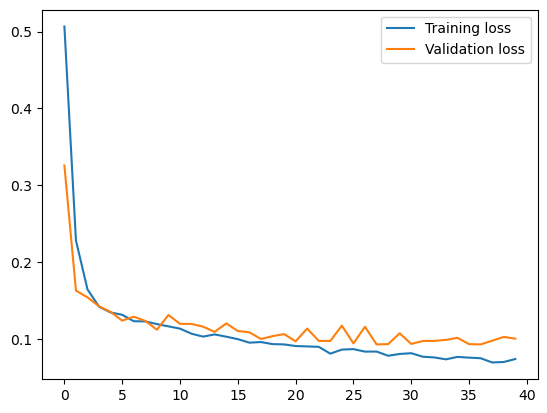

In [48]:
plt.plot(history['train_loss'], label="Training loss")
plt.plot(history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

Using the uniform data instead...

  0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 0.9865


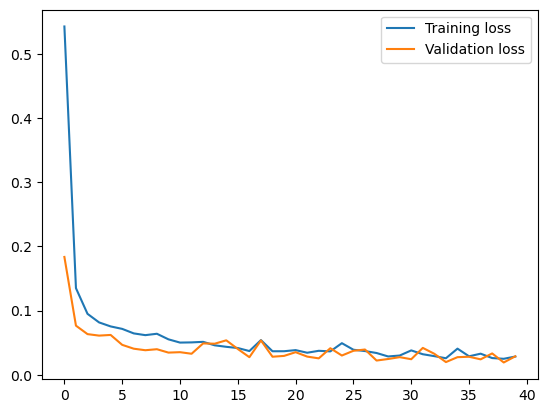

In [50]:
np.random.seed(42)
X, y = synth_data.generate_data(n = 10000, return_uniform=True)

N = X.shape[0]

model = basic_grunet.GRUNetBasic(X.shape[2], 32, 2, 2, 0)
loss_fn = F.binary_cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

train_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X[:int(N*0.8)]).type(torch.float32),
        torch.from_numpy(y[:int(N*0.8)]).type(torch.float32)),
    batch_size=64, shuffle = True)
val_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X[int(N*0.8):]).type(torch.float32),
        torch.from_numpy(y[int(N*0.8):]).type(torch.float32)),
    batch_size=64, shuffle = True)

history = experimentation.fit_model(model, loss_fn, train_loader, val_loader, optimizer, num_epochs=40, verbose=False)

# compute the classification binary accuracy
val_preds = []
val_labs = []
for x_, y_ in val_loader:
    val_preds.append(model(x_.cuda()).detach().cpu().numpy())
    val_labs.append(y_.cpu().numpy())
val_preds = np.concatenate(val_preds)
val_labs = np.concatenate(val_labs)

print(f"Validation accuracy: {np.mean(np.where(val_preds > 0.5, 1.0, 0.0) == val_labs)}")

plt.plot(history['train_loss'], label="Training loss")
plt.plot(history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

## Sampling from $F$

In [18]:
!cat /home/mas322/amex-project/src/experiments/static_preprocessing_methods/experiment_setup.py

import yaml
import os
import importlib
import numpy as np
import torch
import torch.nn.functional as F
import sklearn

from src.lib import experimentation
from src.models import basic_grunet

# undo the min-max preprocessing
def undo_min_max_corrupt_func(X, y):
    """
    X of shape (num_examples, series_length, num_features)
    In this undo, we assume scale same for each feature, over temporal scale
    """
    # to ensure we get the same mins and scales every time
    np.random.seed(42)
    # randomize both the starting point and the feature scales
    mins = np.random.uniform(-1E4, 1E4, size=X.shape[2])[np.newaxis, None]
    # don't set the smallest scale too tiny, otherwise can lose information due to float 32 bit
    scales = 10 ** np.random.uniform(-1, 5, size=X.shape[2])[np.newaxis, None]

    X_corrupt = X * scales + mins
    return X_corrupt, y

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

data_loader_kwargs = {
    'batch_size

In [8]:
U = pyro.distributions.Uniform(0, 1).rv

Available operations:
* Addition
* Subtraction
* Multiplication
* Division
* Absolute values `X.abs()`
* Exponentiation `X.pow(<int>)`
* Negation `X.neg()`
* Exp $e^X$ with `X.exp()`
* Log with `X.log()`
* Sigmoid transform `X.sigmoid()`
* tanh with `X.tanh()`
* Softmax with `X.softmax()`

In [10]:
X = (4 - U).exp()

In [13]:
X.dist.sample((10,))

tensor([23.7435, 32.2350, 47.8166, 26.0117, 22.8435, 52.3709, 38.0960, 33.1339,
        23.0440, 22.2954])

In [120]:
def plot_dist(transform_fn, title = None, n_samples_to_find_boundary=10000):
    U = pyro.distributions.Uniform(0, 1).rv
    X = transform_fn(U)
    
    samples = X.dist.sample((n_samples_to_find_boundary,))
    lower = samples.min()
    upper = samples.max()
    
    xs = torch.linspace(lower, upper, 1000)
    ys = torch.exp(X.dist.log_prob(xs))
    plt.plot(xs, ys)
    plt.xlabel("value in support")
    plt.ylabel("Density")
    if title is not None:
        plt.title(title)
    

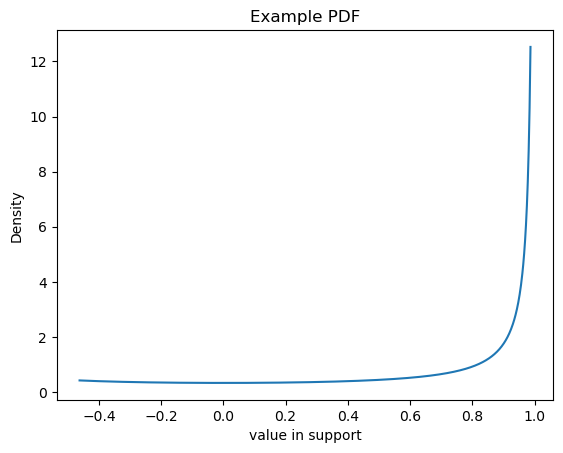

In [121]:
def example_transform(u):
    return (u * 3 - .5).tanh() #+ (u / 10 + 1).exp() * 10
plot_dist(example_transform, "Example PDF")

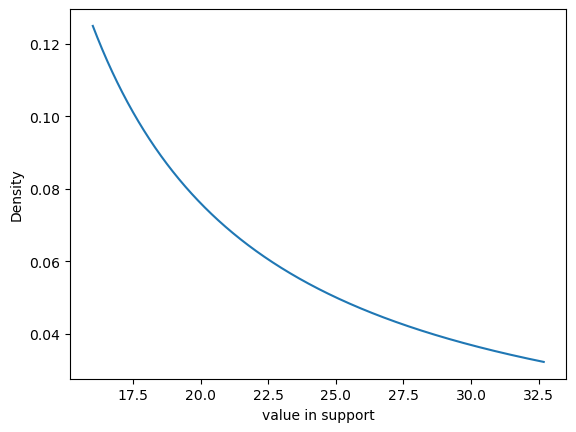

In [145]:
def f(u):
    return (u.exp() + 3).pow(2.)
plot_dist(f)

**Step 1:** Generate correlated uniform random samples:
  - Design a covariance structure with lower-triangular matrix $A \in \mathbb{R}^{(DT) \times (DT)}$, and use this to form the covariance matrix $\Sigma$ (more details on this later), or just use a random matrix $A$ and set $\Sigma=A^\top A$
  - Sample $X \sim \mathcal{N}(0, \Sigma)$, such that $X \in \mathbb{R}^{D\cdot T}$, then reshape to $X \in \mathbb{R}^{D \times T}$
  - Let $U \in \mathbb{R}^{D \times T}$ be formed with $U_{i,j}=\Phi_\mathcal{N}(X_{i,j} \cdot \Sigma_{i\cdot T+j,i\cdot T+j}^{-1/2})$ (it can be shown that $U_{i,j} \sim \textrm{Uniform}[0,1]$)

**Step 2:** Form the response using the uniform random variables:
  - Create the response with $y=\mathbb{I}(\beta_{1,1} U_{1,1}+\dots+\beta_{D,T} U_{D,T}+\zeta > \frac{1}{2})$ where $\zeta \sim \mathcal{N}(0,\sigma_\zeta^2)$ is a noise term

**Step 3:** Form samples from arbitrary distributions with unnormalized PDFs $f_1,\dots,f_D$:
  - ****************Sub-procedure**************** `sample_pdf(f, u)` that takes an unormalized pdf $f$ and a sample $u \sim U[0,1]$ and returns a sample $x$ from $f$ such that $F(x)\approx u$
    - Evaluate `f` on a fine-grid of values with suitable lower- and upper boundaries $A$ and $B$
    - Use `scipy.integrate.cumulative_trapezoid` to efficiently estimate $F(x)=\int_{-\infty}^xf(x')dx'$ for all $x \in \{A,A+\delta x,A+2 \delta x,\dots,B\}=:\mathcal{X}$.
    - Normalize the PDF using the estimate of $F(B)$.
    - Let $\mathcal{F}$ contain the corresponding estimates of $F(x)$
    - Cache an inverse-lookup table $f \in \mathcal{F} \mapsto x \in \mathcal{X}$ (this serves as approximately evaluating $F^{-1}(u)$)
    - Return an approximation for $F^{-1}(u)$
  - For each dimension $d=1,\dots,D$, pass $U_{d,1},\dots,U_{d,T}$ through `sample_pdf` with `f` set to $f_d$ to give $X_{d,1},\dots,X_{d,T}$

In [1]:
import scipy
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

class SynthethicData:
    
    def __init__(self, dim_size, time_series_length, pdfs, pdf_bounds,
                 ar_q, ar_thetas, ar_sigma_noises=None,
                 cross_variables_cor_init_sigma=None,
                 pdf_approximation_number_of_samples=20_000,
                 response_noise_sigma=1e-3, response_thresh=0.5,
                 response_beta_sigma=1.0):
        """
        TODO
        
        :param response_thresh: The treshold for labelling response as 1.
                                The expected number of negative examples is
                                equal to this parameter.
        """
        
        # validate parameters
        if len(pdfs) != dim_size:
            raise ValueError("The number of provided PDFs does not match the number of dimensions")
        if len(pdf_bounds) != dim_size:
            raise ValueError("The number of provided PDF bounds does not match the number of dimensions")
        if q >= time_series_length:
            raise ValueError("q must be less than T")
        if thetas.shape != (dim_size, ar_q + 1):
            raise ValueError("The MA thetas must be of shape (D, q+1)")
        
        # general parameters
        self.D = dim_size
        self.T = time_series_length
        
        # parameters for converting the uniform samples to arbitrary distributions
        self.pdfs = pdfs
        self.pdf_bounds = pdf_bounds
        self.pdf_num_samples = pdf_approximation_number_of_samples
        self.pdf_cache = [None] * dim_size
        
        # parameters for synthesizing the covariance matrix Sigma
        self.q = ar_q
        self.thetas = ar_thetas
        self.ar_sigma_noises = ar_sigma_noises if ar_sigma_noises is not None else np.ones((self.D,))
        self.cor_init_sigma = cross_variables_cor_init_sigma
        self.sigma = None
        
        # parameters used for synthesizing the response
        self.respose_thresh = response_thresh
        self.response_noise_sigma = response_noise_sigma
        self.betas = np.random.normal(loc=0.0, scale=response_beta_sigma, size=(self.D * self.T,))
        # Ignoring the correlation between the Us, we have
        # E( sum(betas @ us) + epsilon ) = sum( E[beta_i] * E[U_i] ) = 1/2 * sum(E[beta_i])
        #                                = DT/2 E[beta_0] =: 0.5
        # We want the above expectation to be equal to 0.5 such that half the responses are positive
        # with the default threshold. Therefore, we recenter the beta expectation to 1/DT
        self.betas = self.betas - np.mean(self.betas) + 1 / (self.D * self.T)
        
    def _sample_pdf(self, f_idx, us):
        """
        Generates samples xs from the f_idx'th pdf such that F(xs) = us
        
        :param f_idx: integer indexing into self.pdfs
        :param us: np.ndarray of shape (num_samples,). The number of
                   samples returned will match this
        :param num_integration_samples: number of samples used to approximate F(x)
        :returns: np.ndarray of same shape as us
        """
        cache = self.pdf_cache[f_idx]
        # we also need to redo the cache if the number of samples changed
        if cache is None:
            A, B = self.pdf_bounds[f_idx]
            xs = np.linspace(A, B, self.pdf_num_samples)

            Fs = scipy.integrate.cumulative_trapezoid(self.pdfs[f_idx](xs), xs, initial = 0)
            # normalize the CDF so endpoint is at 1 (as pdf f might be unnormalized)
            Fs /= np.max(Fs)

            # shape (num_samples, 2):
            #   first column contains F(x)s
            #   second column contains xs
            cache = np.stack([Fs, xs]).T
            self.pdf_cache[f_idx] = cache

        # Find the idx such that F(x[idx]) = us
        cache_idx = np.searchsorted(cache[:, 0], us, side = 'right')
        samples = cache[cache_idx, 1]
        return samples
    
    def _create_responses(self, us):
        """
        :param us: np.ndarray of shape (n, D, T)
        """
        # number of responses to create
        n = us.shape[0]
        epsilons = np.random.normal(scale=self.response_noise_sigma, size=(n,))
        ys = (us.reshape((n, -1)) @ self.betas) + epsilons
        # print(f"epsilon {np.mean(epsilons)}")
        # print(f"betas {np.mean(self.betas)}")
        # print(f"us {np.mean(us)}")
        # print(f"us @ betas + epsilon {np.mean(ys)}")
        # These are normally distributed with mean 0
        # plt.hist(ys, bins = 200)
        # plt.show()
        return np.float32(ys  > self.respose_thresh)
        
    
    def _sample_correlated_uniforms(self, n):
        """
        Returns an array of uniform random variables correlated "like" sigma, where sigma
        is set up initializing self.mvn_sampler
        
        :param n: integer specifying the number of sets of (D, T) samples to generates
        :param sigma: np.ndarray of shape(D * T, D * T) specifying the covariance relation
        :return: np.ndarray of shape (n, D, T)
        """
        mvn_sampler = scipy.stats.multivariate_normal(mean = np.zeros(self.D * self.T), cov = self.sigma, allow_singular=True)
        # shape (n, D * T)
        norm_samples = mvn_sampler.rvs(n)
        u_samples = np.zeros((n, self.D * self.T))
        for i in range(self.D * self.T):
            # the marginal distribution of the MVN will have this std
            norm_obj = scipy.stats.norm(loc = 0., scale = np.sqrt(self.sigma[i, i]))
            # The CDF then gives uniform random samples
            u_samples[:, i] = norm_obj.cdf(norm_samples[:, i])
        
        # shape (n, D, T)
        u_samples = u_samples.reshape((n, self.D, self.T))
        return u_samples
    
    def _isPositiveDefinite(self, A):
        try:
            _ = np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    
    def _find_closest_psd_matrix(self, A):
        """Find the nearest positive-definite matrix to input

        A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
        credits [2].

        Author: Ahmed Fasih [3]

        [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

        [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
        matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
        
        [3] https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite/43244194#43244194
        """

        B = (A + A.T) / 2
        _, s, V = np.linalg.svd(B)

        H = np.dot(V.T, np.dot(np.diag(s), V))

        A2 = (B + H) / 2

        A3 = (A2 + A2.T) / 2

        if self._isPositiveDefinite(A3):
            return A3

        spacing = np.spacing(np.linalg.norm(A))
        # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
        # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
        # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
        # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
        # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
        # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
        # `spacing` will, for Gaussian random matrixes of small dimension, be on
        # othe order of 1e-16. In practice, both ways converge, as the unit test
        # below suggests.
        I = np.eye(A.shape[0])
        k = 1
        while not self._isPositiveDefinite(A3):
            mineig = np.min(np.real(np.linalg.eigvals(A3)))
            A3 += I * (-mineig * k**2 + spacing)
            k += 1

        return A3

    def _ar_acvs(self, tau, thetas, sigma_noise):
        # assumed the first element is -1
        if thetas[0] != -1:
            raise ValueError("The first theta of the AR(q) params is not -1")

        q = thetas.shape[0] - 1
        s_tau = 0
        for j in range(q - tau + 1):
            s_tau += thetas[j] * thetas[j + tau]
        return s_tau * sigma_noise ** 2

    def _create_covariance_matrix(self, thetas):
        if self.cor_init_sigma is not None:
            A = np.random.normal(loc = 0, scale = self.cor_init_sigma, size = (D * T, D * T))
            A = np.tril(A)
        else:
            A = np.zeros((D * T, D * T))
        
        # When we later sample MVN of shape (DT), we will unroll
        # one row at a time:
        # > np.arange(1, 11).reshape((D, T))
        # array([[ 1,  2,  3,  4,  5],
        #        [ 6,  7,  8,  9, 10]])
        # Therefore, to get (D, T) indexing, we use (d * T + i) when
        # indexing into A. We also want to make a lower-triangular
        # matrix, so the highest index should come first
        for d in range(D):
            # all possible lags
            for tau in range(T):
                # all valid starting entries
                for i in range(T - tau):
                    # we are setting the correlation between U[d,i] and U[d,i+tau]
                    A[(d * T + i) + tau , d * T + i] =\
                        self._ar_acvs(tau, self.thetas[d, :], self.ar_sigma_noises[d])
        # to preserve the diagonals, reset them after adding the transpose
        sigma = A + A.T
        np.fill_diagonal(sigma, np.diag(A))
        return self._find_closest_psd_matrix(sigma)
    
    def generate_data(self, n, return_uniform = False):
        """
        Generates correlated Xs and corresponding responses y
        
        :return: tuple (X, y) where X is an np.ndarray of shape (n, D, T) and y is of shape (n,)
        """
        
        if self.sigma is None:
            self.sigma = self._create_covariance_matrix(self.thetas)
            print(self.sigma)
        
        # shape (n, D, T)
        us = self._sample_correlated_uniforms(n)
        # shape (n,)
        ys = self._create_responses(us)
        
        # corrupt the data using our PDFs and u samples
        Xs = np.zeros((n, self.D, self.T))
        for f_idx in range(self.D):
            Xs[:, f_idx, :] = self._sample_pdf(f_idx, us[:, f_idx, :].reshape(-1)).reshape((n, self.T))
            
        if return_uniform:
            return np.float32(us), ys
        else:
            return np.float32(Xs), ys

In [321]:
D = 2
T = 6
# lower bound, upper bound, and unormalized PDF
bounds = [(-3, 5), (-4, 16)]
f1 = lambda x: 10 * scipy.stats.norm.cdf(10 * x) * scipy.stats.norm.pdf(x)
f2 = lambda x: scipy.stats.norm.pdf(x - 6)
# both of the two time-series will be q=3 and q=2, respecitvely
thetas = np.array([
    [-1., 0.5, -0.2, 0.8],
    [-1., 0.3, 0.9, 0.0]
])

synth_data = SynthethicData(
    dim_size = D,
    time_series_length = T,
    pdfs = [f1, f2],
    pdf_bounds = bounds,
    ar_q = 3,
    ar_thetas = thetas,
    cross_variables_cor_init_sigma=1.0,
)

np.random.seed(43)
X, y = synth_data.generate_data(n = 1000, return_uniform=True)

[[ 2.54307553e+00 -8.46331019e-01  6.49808192e-01 -7.03315847e-01
  -1.35644524e-02 -2.20027850e-01  1.65419692e+00  1.33309493e+00
  -1.26031489e-01 -1.66797340e+00 -2.87253282e-01  1.70913039e-01]
 [-8.46331019e-01  2.18271584e+00 -9.78497592e-01  6.54318336e-01
  -5.63780908e-01  1.63452043e-01 -8.38427544e-01 -1.28073214e+00
  -2.39168669e-02  1.91174455e-01  6.39151197e-01 -6.10552885e-01]
 [ 6.49808192e-01 -9.78497592e-01  2.44062801e+00 -6.89462590e-01
   4.20781611e-01 -8.29307754e-01 -9.78485855e-02  1.34882717e+00
   1.40983973e+00 -2.60798564e-01 -1.71495380e+00  4.92860450e-01]
 [-7.03315847e-01  6.54318336e-01 -6.89462590e-01  2.04540952e+00
  -6.81978920e-01  5.29689220e-01 -9.80592923e-01 -5.75444372e-01
   4.85670929e-01  1.65417665e-02 -1.08515334e-01 -6.01129215e-01]
 [-1.35644524e-02 -5.63780908e-01  4.20781611e-01 -6.81978920e-01
   2.16127237e+00 -6.28046116e-01  3.18953154e-02 -7.71912766e-01
   3.25871811e-01 -3.03583089e-01 -6.38013257e-01  2.41687198e-01]
 [-2.

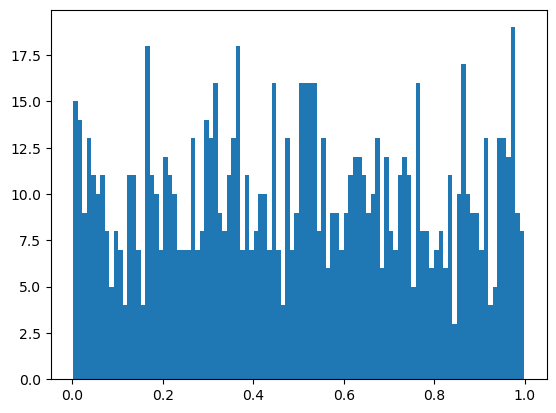

In [323]:
# see the distribution for one of the timestamps for the second time-series
plt.hist(X[:, 1, 3], bins = 100)
plt.show()

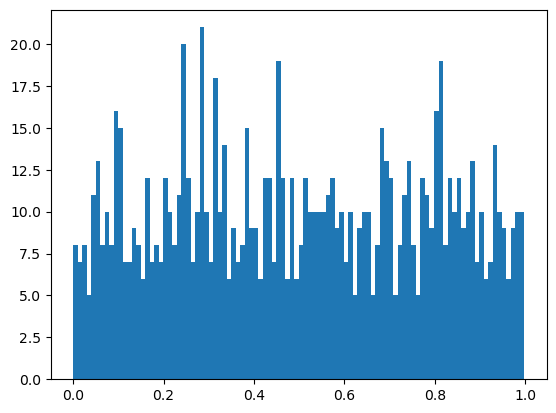

In [324]:
# see the distribution for one of the timestamps for the first time-series
plt.hist(X[:, 0, 3], bins = 100)
plt.show()

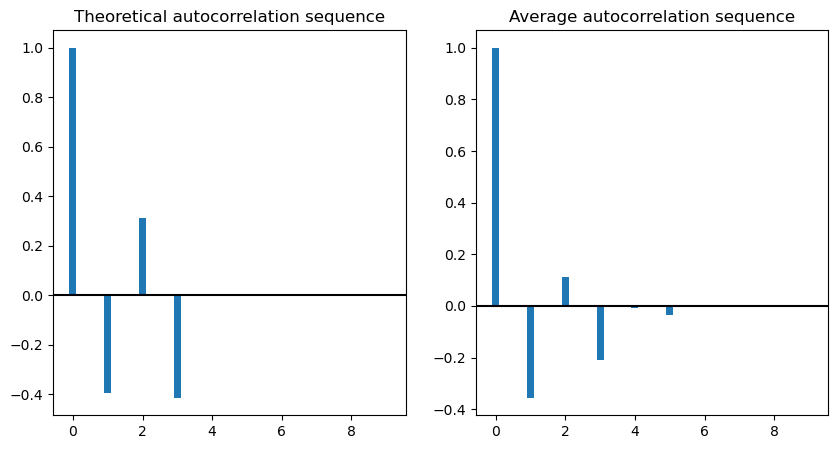

In [325]:
time_series_idx = 0

def sample_acvs(xs, tau):
    x_bar = np.mean(xs)
    N = len(xs)
    autoCov = 0
    for i in np.arange(0, N-tau):
        autoCov += ((xs[i+tau])-x_bar)*(xs[i]-x_bar)
    return (1/(N-1))*autoCov

fig, axs = plt.subplots(ncols=2, figsize = (10, 5))

# theoretical acvs for the first time-series
acvs = []
for tau in range(10):
    # normalize so we get the auto correlation sequence
    acvs.append(synth_data._ar_acvs(tau, thetas[time_series_idx, :], 1.0) / synth_data._ar_acvs(0, thetas[0, :], 1.0))
axs[0].bar(np.arange(10), acvs, width = 0.2)
axs[0].axhline(0, color='black')
axs[0].set_title("Theoretical autocorrelation sequence")

# sample acvs for the first time-series
acvs = []
for tau in range(10):
    acvs.append(np.mean([sample_acvs(X[i, time_series_idx, :], tau) for i in range(X.shape[0])]))
# normalize so we get the auto correlation sequence
acvs = np.array(acvs) / acvs[0]
axs[1].bar(np.arange(10), acvs, width = 0.2)
axs[1].axhline(0, color='black')
axs[1].set_title("Average autocorrelation sequence")
plt.show()

In [322]:
# test if any mutual information between X and y
import sklearn
from sklearn.linear_model import LogisticRegression

X2 = X.reshape((X.shape[0], -1))

mod = LogisticRegression(max_iter=500)
mod.fit(X2, y)

mod.score(X2, y)

0.968

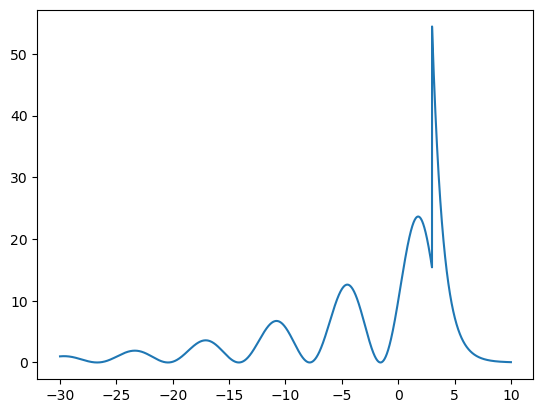

In [33]:
xs = np.linspace(-30, 10, 10000)
def f(x):
    return np.where(x > 3, np.exp(7-x), np.exp(x / 10) * (10 * np.sin(x) + 10))

plt.plot(xs, f(xs))

In [87]:
D = 1 / np.sqrt(np.diag(sigma))
pd.DataFrame(D * sigma * D)

,0,1,2
0,1.0,0.50,0.00
1,0.5,1.00,0.25
2,0.0,0.25,1.00


$$s_\tau=\sigma_\epsilon^2 \sum_{j=0}^{q-\tau} \theta_{j,q} \theta_{j+\tau,q}$$

In [136]:
A = np.random.normal(size = (10000, 13))
B = np.random.normal(size = (13,))
(A @ B).shape

(10000,)

In [134]:
B

14.206872651099928

In [139]:
np.float32(np.random.normal(size = (8,)) > 0.5)

array([1., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [263]:
X.shape

(1000, 2, 10)